# CSE 152A Fall 2022 – Assignment 3

Assignment Published On: **Wed, Nov 9, 2022**

Due On: **Fri, Nov 18, 2022 5:00 PM (Pacific Time)**

Instructions:
- Attempt all questions.
- Please comment all your code adequately.
- **Please install following packages in order to run the code: OpenCV, matplotlib, scikit-learn**
- Please write your code at the ``WRITE YOUR CODE HERE'' prompt in the .ipynb file. 

## Problem 1: Image Classiﬁcation Using Bag-of-words [20 pts]

We will now build a classifier to determine whether an input image contains a face. A training dataset has been provided consisting of images with and without faces. We will create a bag-of-words representation for images and use K-nearest neighbor classification. 

**Note**: For this problem, it is not important to get high accuracies, but just be able to see how an example of an entire pipeline for image classification works.

## Review of bag-of-words for image classification

We will solve image classification, with the relatively simple but effective bag-of-words approach. We treat an image as a set of regions and ignore the spatial relationships between different regions. The image classification problem can then be solved by counting the frequencies of different regions appearing in an image. Image classification using bag-of-words includes the following steps: 

* **Region Selection**: Select some regions in the images so that we can extract features from those regions in the next step. The regions can be selected by feature detection methods like edge or corner detection, or you can just uniformly sample the image. 

* **Feature Extraction**: We extract features from the selected regions. One commonly used feature is SIFT. We extract features from every image in the training set. These features are collected to compute the visual vocabulary for image representation.  

* **Building visual vocabulary**: Once we have the features extracted from training images, we build a visual vocabulary by grouping them together to form a few clusters. We will use the k-means algorithm to group the features. The reason why we need this step is to reduce the redundancy in feature space and have a more concise feature representation of images. 

* **Learning and recognition**: Given the visual vocabulary, each training image is represented by a histogram, where the features in the image populate bins that correspond to the visual word closest to them. Thereafter, we will use k-nearest neighbors to perform classification for a test image, also represented by a histogram using the same vocabulary.

## Simple face classifier
We will make a classifier to tell whether there is a face in a given image. The dataset contains 200 images with faces and 200 images without faces. We will pick 100 images from each group for training and the other 100 images for testing. The skeleton code is given.

In [1]:
import glob
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math

# Parameters
posData = 'images/face/'
negData = 'images/nonface/'
posTrainRatio = 0.5
negTrainRatio = 0.5
imSize = 133, 200 # resize each image to this size
nIntPts = 200 # maximum number of interest points to be extracted from an image
wGrid = 5 # width of the small grids for uniform sampling
patchSize = 11 # an odd number indicate patch size for image patch feature
nCluster = 50 # number of cluster in k-means algorithm

def listImage(dataRoot):
    fileList = glob.glob(str(dataRoot + '*.jpg'))
    imNum = len(fileList)
    fileList = [fileList[i].replace('\\', '/') for i in range(imNum)]
    return fileList

def loadImage(imgName, imSize):
    # load image, resize and make RGB to grayscale
    img = cv2.imread(imgName)
    img = cv2.resize(img, (imSize[1], imSize[0]))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def createSplit(imgList, ratio):
    random.shuffle(imgList)
    trainList = imgList[:round(len(imgList)*ratio)]
    testList = imgList[round(len(imgList)*ratio):]
    return trainList, testList

# Data preprocessing: Create Training / Testing Split
posList = listImage(posData)
negList = listImage(negData)
trainPosList, testPosList = createSplit(posList, posTrainRatio)
trainNegList, testNegList = createSplit(negList, negTrainRatio)
trainList = trainPosList + trainNegList
trainLabel = np.concatenate((np.ones(len(trainPosList)), np.zeros(len(trainNegList))))
testList = testPosList + testNegList
testLabel = np.concatenate((np.ones(len(testPosList)), np.zeros(len(testNegList))))
testPosLabel = np.ones(len(testPosList))
testNegLabel = np.zeros(len(testNegList))

## 1.1 Extract interest points from images [2 pts]

You will now try two methods for this: 

* **(a) Uniformly sample the images.** You can divide the image into regular grids and choose a point in each grid and then uniformly choose `nPts` number of interest points. 
* **(b) Sample on corners.** First use the Harris Corner detector to detect corners in the image and then uniformly choose `nPts` number of interest points. (This has already been implemented for you as an example.) 

Interest Points extracted by uniform (above) and edge (below) method:


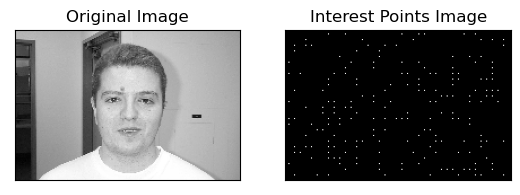

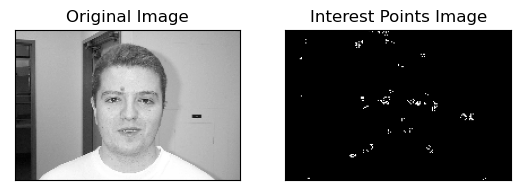

In [2]:
def uniformSampling(imSize, nPts, wGrid):
    ''' Uniformly sample the images.
    Args: 
        imSize: size of images (height, width)
        nPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
    Return:
        pts: a list of interest points (Yi, Xi)
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Store the height of the subimages
    height = imSize[0]
    # Store the width of the subimages
    width = imSize[1]
    # Array with all the point
    all_points = []
    
    # Iterate through the image grid by grid
    for y in range(0,height,wGrid):
        for x in range(0, width, wGrid):
            
            # Upper bounds of the grid 
            y_upper = y + wGrid
            x_upper = x + wGrid
            
            # Ensure the grid is completely within the image
            if y_upper < height and x_upper < width:
                
                # Compute the center of the grid
                center_y = math.ceil((y + y_upper)/2)
                center_x = math.ceil((x + x_upper)/2)

                # Append the point as a tuple
                all_points.append((center_y, center_x))
    
    # Select nPts random points form all of them
    pts = random.sample(all_points,nPts)

    return pts

def cornerSampling(img, nPts):
    '''
    Args: 
        img: image which you want to extract interest points
        nPts: maximum number of interest points to be extracted
    Return:
        pts: a list of interest points (Yi, Xi)
    '''
    dst = cv2.cornerHarris(img,2,3,0.04)
    dst = cv2.dilate(dst,None)
    cor = np.zeros(img.shape)
    cor[dst>0.01*dst.max()]=[1]
    ptsY, ptsX = np.where(cor==1)
    num = min(nPts, len(ptsY))
    choice = np.random.choice(len(ptsY), num, replace=False)
    ptsY = ptsY[choice]
    ptsX = ptsX[choice]
    pts = [(ptsY[i], ptsX[i]) for i in range(num)]
    return pts

def plotInterestPoints(img, pts, idx=0):
    ptsMap = np.zeros(img.shape)
    ptsY = [Y for Y, X in pts]
    ptsX = [X for Y, X in pts]
    ptsMap[ptsY, ptsX] = 1
    plt.figure(idx)
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(ptsMap,cmap = 'gray')
    plt.title('Interest Points Image'), plt.xticks([]), plt.yticks([])

# Here is the code for you to test your implementation
sampleImg = loadImage(trainList[0], imSize)
print('Interest Points extracted by uniform (above) and edge (below) method:')
ptsU = uniformSampling(imSize, nIntPts, wGrid)
plotInterestPoints(sampleImg, ptsU, idx=0)
ptsE = cornerSampling(sampleImg, nIntPts)
plotInterestPoints(sampleImg, ptsE, idx=1)

## 1.2. Extract features [2 pts]
You are required to try two kinds of features: 
* **(a) SIFT feature.** Here we use the SIFT implementation in *OpenCV* package (this has already been implemented for you as an example). 
* **(b) Image Patch feature.** Extract a small image patch around each feature point. You can decide the size of each patch and how many pixels it should cover on you own. 

In [3]:
def extractSIFTfeature(img, pts):
    '''
    Args:
        img: input image
        pts: detected interest points in the previous step
    Return:
        features: a list of SIFT descriptor features for each interest point
    '''
    sift = cv2.SIFT_create()
    kp = [cv2.KeyPoint(float(ptsX), float(ptsY), 1) for ptsY, ptsX in pts]
    _, des = sift.compute(img, kp)
    features = [des[i] for i in range(des.shape[0])]
    return features

def extractImagePatchfeature(img, pts, patchSize):
    '''
    Args:
        img: input image
        pts: detected interest points in the previous step
        patchSize: an odd number indicate patch size
    Return:
        features: a list of image patch features (1-d) for each interest point
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Height and width of the image
    height = np.shape(img)[0]
    width = np.shape(img)[1]
    
    # Separation from the center
    aux = patchSize//2
    
    # Create the empty array
    features = np.zeros((1,(patchSize-1)*(patchSize-1)))
    
    # Iterate through the interest points
    for point in pts:
        # Center coordinates
        y = point[0]
        x = point[1]
        # Avoid out of bounds: only patches completely within the image range will be selected
        if ((y-aux) >= 0) and ((x-aux) >= 0) and ((y+aux) <= height) and ((x+aux) <= width):
            # Store the patch around the point
            patch = img[y-aux:y+aux,x-aux:x+aux]
            # Reshape the patch
            patch_1d = patch.flatten()
            # Append the patch to the features array
            features = np.row_stack((features, patch_1d))
    
    # Eliminate the first row which was used to create the array      
    features = features[1::]
    
    return features
    
# Here is the code for you to test your implementation
featSIFT = extractSIFTfeature(sampleImg, ptsE)
print('length of SIFT feature list', len(featSIFT))
print('dimension of feature', featSIFT[0].shape)
featPatch = extractImagePatchfeature(sampleImg, ptsE, patchSize)
print('length of Image Patch feature list', len(featPatch))
print('dimension of feature', featPatch[0].shape)

length of SIFT feature list 200
dimension of feature (128,)
length of Image Patch feature list 184
dimension of feature (100,)


## 1.3. Build visual vocabulary [4 pts]
Use k-means clustering to form a visual vocabulary. You can use the python k-means package. You can decide the number of clusters yourself. The default number of cluster centers in k-means is 50. 

In [4]:
from sklearn.cluster import KMeans

def getImgFeat(img, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    ''' Output a list of detected features for an image
    Args: 
        img: image which you want to extract interest points
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        extractFeatList: a list of image patch features (1-d) for each interest point
    '''
    if ptType == 'uniform':
        intPts = uniformSampling(imSize, nIntPts, wGrid)
    elif ptType == 'corner':
        intPts = cornerSampling(img, nIntPts)
    else:
        assert False, 'ptType must be either uniform or corner'
        
    if featType == 'sift':
        extractFeatList = extractSIFTfeature(img, intPts)
    elif featType == 'patch':
        extractFeatList = extractImagePatchfeature(img, intPts, patchSize)
    else:
        assert False, 'featType must be either sift or patch'
        
    return extractFeatList

def collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    ''' Collect extracted features for each image among training data
    Args:
        trainList: list of images filepath
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        feats: (# of features, dim of feature) array
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Create the array containing the feats
    feats = np.array([])
    
    # Obtain the features image by image
    for imgPath in trainList:
        
        # Load the image
        img = loadImage(imgPath, imSize)
        
        # Uniform sampling
        if ptType == 'uniform':
            # Obtain the nterest points 
            pts = uniformSampling(imSize, nIntPts, wGrid)
        # Corner sampling
        elif ptType == 'corner':
            # Obtain the interest points 
            pts = cornerSampling(img, nIntPts)
            
        # Extract the features of the image
        
        # SIFT extraction
        if featType == 'sift':
            features = extractSIFTfeature(img, pts)
            features_length = len(features[0])
        # Patch extraction
        elif featType == 'patch':
            features = extractImagePatchfeature(img, pts, patchSize)
            features_length = features.shape[1]
        
        # Append the new features to the main array
        feats = np.append(feats,features)

    # Reshape the array to ensure we have a shape (# total features, # feature length)
    feats = np.reshape(feats, (int(feats.shape[0]/features_length),features_length))
    
    return feats

def formVisualVocab(feats, nCluster):
    ''' Use k-means algorithm to find k cluster centers, output k-means model
    Args: 
        feats: list of features collected from training data
        nCluster: number of cluster in k-means algorithm
    Return:
        model: k-means model for following steps
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Intiate the K-Means
    kmeans = KMeans(init="random",n_clusters=nCluster)
    # Train the model
    model = kmeans.fit(feats)
    
    return model

# Here is the code for you to test your implementation
feats = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(feats.shape) # should be (total number of extracted features, dim of feature)
model = formVisualVocab(feats, nCluster)
centers = model.cluster_centers_
print(centers.shape) # should be (nCluster, dim of feature)

(20000, 128)
(50, 128)


## 1.4. Compute histogram representation [4 pts]
Compute the histogram representation of each image, with bins defined over the visual words in the vocabulary. These histograms are the bag-of-words representations of images that will be used for image classiﬁcation. 

In [5]:
def getHistogram(img, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    '''
    Calculate histogram representation for single image
    Args:
        img: input image
        model: k-means model from previous step
        nCluster: number of cluster in k-means algorithm
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        hist: histogram representation (1-d) for input image
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Create the empty 1D array with length nCluster
    hist = np.zeros((nCluster), dtype = "int")
    # Extract image features
    features = getImgFeat(img, imSize, nIntPts, wGrid, patchSize, ptType, featType)
    # Assign each feature to a center/cluster
    pred_centers = model.fit_predict(features)
    # Store the number of times each center appears
    for i in range(nCluster):
        hist[i] = np.count_nonzero(pred_centers == i)
    
    return hist
    
def computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    ''' Compute histogram representation for whole training dataset
    Args: 
        trainList: list of images filepath
        model: k-means model from formVisualVocab
        nCluster: number of cluster in k-means algorithm
        imSize: size of images (height, width)
        nIntPts: maximum number of interest points to be extracted
        wGrid: width of the small grids
        patchSize: an odd number indicate patch size
        ptType: 'uniform' or 'corner' indicates the interest pts sampling method
        featType: 'sift' or 'patch' indicates the feature extraction method
    Return:
        hists: (# of images, nCluster) array - histogram representations among training dataset
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Create the array 'hists' with shape (# of images, nCluster)
    hists = np.zeros((1, nCluster), dtype = "int")
    
    # Obtain the features image by image
    for i in range(len(trainList)):
        
        # Load the image
        img = loadImage(trainList[i], imSize)
        
        # Extract the histogram
        histogram = getHistogram(img, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType)
        
        # Store the histogram in the main array
        hists = np.row_stack((hists,histogram))
    
    # Remove the first row I used to create the array
    hists = hists[1:,:]

    return hists
    
# Here is the code for you to test your implementation
hist = getHistogram(sampleImg, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(hist.shape) # should be (nCluster)
hists = computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(hists.shape) # should be (# of training images, nCluster)

(50,)
(100, 50)


## 1.5. K nearest neighbor classifier [4 pts]
After building the visual vocabulary, we now do image classiﬁcation using the nearest neighbors method. Given a new image, first represent it using the visual vocabulary and then find the closest representation in the training set. The test image is assigned the same category as its nearest neighbor in the training set. Next, to make the algorithm more robust, find the first K-nearest neighbors (for K = 3 and 5). 


In [6]:
from sklearn.neighbors import KNeighborsClassifier

def KNNclassifier(trainX, trainY, n_neighbors):
    ''' Return a KNN model by fitting training data (trainX, trainY)
    Args:
        trainX: a (# of images, nCluster) array of BoW features for training data
        trainY: a (# of images) array of class label for training data
        n_neighbors: # of neighbors used in KNN classifier
    Return:
        model: KNN classifier model
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Create the KNN
    knn = KNeighborsClassifier(n_neighbors)
    # Train the model
    model = knn.fit(trainX, trainY)
    
    return model

def getAccuracy(testX, testY, model):
    ''' Output the testing accuracy for KNN classifier model 
    Args:
        testX: a (# of images, nCluster) array of BoW features for testing data
        testY: a (# of images) array of class label for testing data
        model: KNN classifier model
    Return:
        accu: accuracy of classification prediction on testing data
    '''
    #-------------------------------------#
    #         WRITE YOUR CODE HERE        #
    #-------------------------------------#
    
    # Make predictions for the testing set
    pred = model.predict(testX)
    # Check the accuracy
    counter = np.count_nonzero(pred == testY)
    # Accuracy
    accu = counter/len(testY)  
    
    return accu

# Here is the code for you to test your implementation
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
model = KNNclassifier(X, y, n_neighbors=3)
print(model.predict([[1.1]])) # Should be [0]
Xp = [[0.5], [2.5]]
Yp = [0, 0]
acc = getAccuracy(Xp, Yp, model)
print(acc) # Should be 0.5

[0]
0.5


## 1.6. Calculate testing accuracy [4 pts]
Use `50 clusters` in k-means and keep other hyperparameters as default, try `K=3` and `K=5` for KNN classifier respectively, report the accuracy in the following two 2D tables. You should report the accuracy of each method on both positive and negative testing samples. Some of the methods may have poor accuracy. But that is fine, don't worry too much about accuracy. You will get full credit as long as you can correctly implement and reason about the various methods. 

In [7]:
# Train list feats
trainFeats_uniform_sift = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, 'uniform', 'sift')
trainFeats_corner_sift = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, 'corner', 'sift')
trainFeats_uniform_patch = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, 'uniform', 'patch')
trainFeats_corner_patch = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, 'corner', 'patch')

# Train models
modelTrain_uniform_sift = formVisualVocab(trainFeats_uniform_sift, nCluster)
modelTrain_corner_sift = formVisualVocab(trainFeats_corner_sift, nCluster)
modelTrain_uniform_patch = formVisualVocab(trainFeats_uniform_patch, nCluster)
modelTrain_corner_patch = formVisualVocab(trainFeats_corner_patch, nCluster)

# Train histograms
histTrain_uniform_sift = computeHistograms(trainList, modelTrain_uniform_sift, nCluster, imSize, nIntPts, wGrid, patchSize, 'uniform', 'sift')
histTrain_corner_sift = computeHistograms(trainList, modelTrain_corner_sift, nCluster, imSize, nIntPts, wGrid, patchSize, 'corner', 'sift')
histTrain_uniform_patch = computeHistograms(trainList, modelTrain_uniform_patch, nCluster, imSize, nIntPts, wGrid, patchSize, 'uniform', 'patch')
histTrain_corner_patch = computeHistograms(trainList, modelTrain_corner_patch, nCluster, imSize, nIntPts, wGrid, patchSize, 'corner', 'patch')

In [8]:
# 3-KNN classifiers
knn3_uniform_sift = KNNclassifier(histTrain_uniform_sift, trainLabel, n_neighbors=3)
knn3_corner_sift = KNNclassifier(histTrain_corner_sift, trainLabel, n_neighbors=3)
knn3_uniform_patch = KNNclassifier(histTrain_uniform_patch, trainLabel, n_neighbors=3)
knn3_corner_patch = KNNclassifier(histTrain_corner_patch, trainLabel, n_neighbors=3)

# 5-KNN classifiers
knn5_uniform_sift = KNNclassifier(histTrain_uniform_sift, trainLabel, n_neighbors=5)
knn5_corner_sift = KNNclassifier(histTrain_corner_sift, trainLabel, n_neighbors=5)
knn5_uniform_patch = KNNclassifier(histTrain_uniform_patch, trainLabel, n_neighbors=5)
knn5_corner_patch = KNNclassifier(histTrain_corner_patch, trainLabel, n_neighbors=5)

In [9]:
# Postive test list feats
posTestFeats_uniform_sift = collectFeat(testPosList, imSize, nIntPts, wGrid, patchSize, 'uniform', 'sift')
posTestFeats_corner_sift = collectFeat(testPosList, imSize, nIntPts, wGrid, patchSize, 'corner', 'sift')
posTestFeats_uniform_patch = collectFeat(testPosList, imSize, nIntPts, wGrid, patchSize, 'uniform', 'patch')
posTestFeats_corner_patch = collectFeat(testPosList, imSize, nIntPts, wGrid, patchSize, 'corner', 'patch')

# Postive test models
modelPosTest_uniform_sift = formVisualVocab(posTestFeats_uniform_sift, nCluster)
modelPosTest_corner_sift = formVisualVocab(posTestFeats_corner_sift, nCluster)
modelPosTest_uniform_patch = formVisualVocab(posTestFeats_uniform_patch, nCluster)
modelPosTest_corner_patch = formVisualVocab(posTestFeats_corner_patch, nCluster)

# Positive test histograms
histPosTest_uniform_sift = computeHistograms(testPosList, modelPosTest_uniform_sift, nCluster, imSize, nIntPts, wGrid, patchSize, 'uniform', 'sift')
histPosTest_corner_sift = computeHistograms(testPosList, modelPosTest_corner_sift, nCluster, imSize, nIntPts, wGrid, patchSize, 'corner', 'sift')
histPosTest_uniform_patch = computeHistograms(testPosList, modelPosTest_uniform_patch, nCluster, imSize, nIntPts, wGrid, patchSize, 'uniform', 'patch')
histPosTest_corner_patch = computeHistograms(testPosList, modelPosTest_corner_patch, nCluster, imSize, nIntPts, wGrid, patchSize, 'corner', 'patch')

In [10]:
# Negative test list feats
negTestFeats_uniform_sift = collectFeat(testNegList, imSize, nIntPts, wGrid, patchSize, 'uniform', 'sift')
negTestFeats_corner_sift = collectFeat(testNegList, imSize, nIntPts, wGrid, patchSize, 'corner', 'sift')
negTestFeats_uniform_patch = collectFeat(testNegList, imSize, nIntPts, wGrid, patchSize, 'uniform', 'patch')
negTestFeats_corner_patch = collectFeat(testNegList, imSize, nIntPts, wGrid, patchSize, 'corner', 'patch')

# Negative test models
modelNegTest_uniform_sift = formVisualVocab(negTestFeats_uniform_sift, nCluster)
modelNegTest_corner_sift = formVisualVocab(negTestFeats_corner_sift, nCluster)
modelNegTest_uniform_patch = formVisualVocab(negTestFeats_uniform_patch, nCluster)
modelNegTest_corner_patch = formVisualVocab(negTestFeats_corner_patch, nCluster)

# Negative test histograms
histNegTest_uniform_sift = computeHistograms(testNegList, modelNegTest_uniform_sift, nCluster, imSize, nIntPts, wGrid, patchSize, 'uniform', 'sift')
histNegTest_corner_sift = computeHistograms(testNegList, modelNegTest_corner_sift, nCluster, imSize, nIntPts, wGrid, patchSize, 'corner', 'sift')
histNegTest_uniform_patch = computeHistograms(testNegList, modelNegTest_uniform_patch, nCluster, imSize, nIntPts, wGrid, patchSize, 'uniform', 'patch')
histNegTest_corner_patch = computeHistograms(testNegList, modelNegTest_corner_patch, nCluster, imSize, nIntPts, wGrid, patchSize, 'corner', 'patch')

In [11]:
# Positive models accuracies (3-KNN)
accu3Pos_uniform_sift = getAccuracy(histPosTest_uniform_sift, testPosLabel, knn3_uniform_sift)
accu3Pos_corner_sift = getAccuracy(histPosTest_corner_sift, testPosLabel, knn3_corner_sift)
accu3Pos_uniform_patch = getAccuracy(histPosTest_uniform_patch, testPosLabel, knn3_uniform_patch)
accu3Pos_corner_patch = getAccuracy(histPosTest_corner_patch, testPosLabel, knn3_corner_patch)

# Positive models accuracies (5-KNN)
accu5Pos_uniform_sift = getAccuracy(histPosTest_uniform_sift, testPosLabel, knn5_uniform_sift)
accu5Pos_corner_sift = getAccuracy(histPosTest_corner_sift, testPosLabel, knn5_corner_sift)
accu5Pos_uniform_patch = getAccuracy(histPosTest_uniform_patch, testPosLabel, knn5_uniform_patch)
accu5Pos_corner_patch = getAccuracy(histPosTest_corner_patch, testPosLabel, knn5_corner_patch)

# Negative models accuracies (3-KNN)
accu3Neg_uniform_sift = getAccuracy(histNegTest_uniform_sift, testNegLabel, knn3_uniform_sift)
accu3Neg_corner_sift = getAccuracy(histNegTest_corner_sift, testNegLabel, knn3_corner_sift)
accu3Neg_uniform_patch = getAccuracy(histNegTest_uniform_patch, testNegLabel, knn3_uniform_patch)
accu3Neg_corner_patch = getAccuracy(histNegTest_corner_patch, testNegLabel, knn3_corner_patch)

# Negative models accuracies (5-KNN)
accu5Neg_uniform_sift = getAccuracy(histNegTest_uniform_sift, testNegLabel, knn5_uniform_sift)
accu5Neg_corner_sift = getAccuracy(histNegTest_corner_sift, testNegLabel, knn5_corner_sift)
accu5Neg_uniform_patch = getAccuracy(histNegTest_uniform_patch, testNegLabel, knn5_uniform_patch)
accu5Neg_corner_patch = getAccuracy(histNegTest_corner_patch, testNegLabel, knn5_corner_patch)

                              K=3
|             |  Uniform   | Uniform |  Corners  | Corners |
|:------------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Positive | Negative |
| SIFT Feature |    {{accu3Pos_uniform_sift}}     |   {{accu3Neg_uniform_sift}}      |    {{accu3Pos_corner_sift}}    |    {{accu3Neg_corner_sift}}     |
|  Image Patch |     {{accu3Pos_uniform_patch}}    |     {{accu3Neg_uniform_patch}}    |     {{accu3Pos_corner_patch}}    |    {{accu3Neg_corner_patch}}    |

                              K=5
|             |  Uniform   | Uniform |  Corners  | Corners |
|:------------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Positive | Negative |
| SIFT Feature |    {{accu5Pos_uniform_sift}}     |   {{accu5Neg_uniform_sift}}      |    {{accu5Pos_corner_sift}}    |    {{accu5Neg_corner_sift}}     |
|  Image Patch |     {{accu5Pos_uniform_patch}}    |     {{accu5Neg_uniform_patch}}    |     {{accu5Pos_corner_patch}}    |    {{accu5Neg_corner_patch}}    |

## Problem 2:  Bayesian Estimation [20 pts]
**Note**: You can just use pen and paper to do the computations for this problem. It is also fine to use Python or any other means to do the computations.

We wish to classify cells observed in tissues imaged through a microscope into healthy and unhealthy. Cells that are not healthy are typically larger in area. Our training data consists of 100 cells labeled as unhealthy and 200 cells labeled as healthy, with the distribution shown in Table 1.

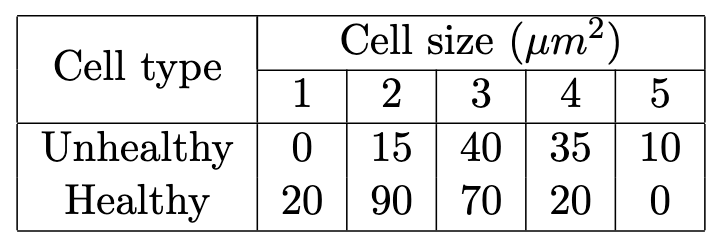
Table 1: Distribution of unhealthy and healthy cells.      

**2.1** Consider histogram representations for the likelihoods $P(area|healthy)$ and $P(area|unhealthy)$. Each histogram has 5 bins, of width $1$ unit each and centered at $1, 2, \cdots, 5$. Draw an approximate sketch of the histograms in two separate figures. **[3 points]**

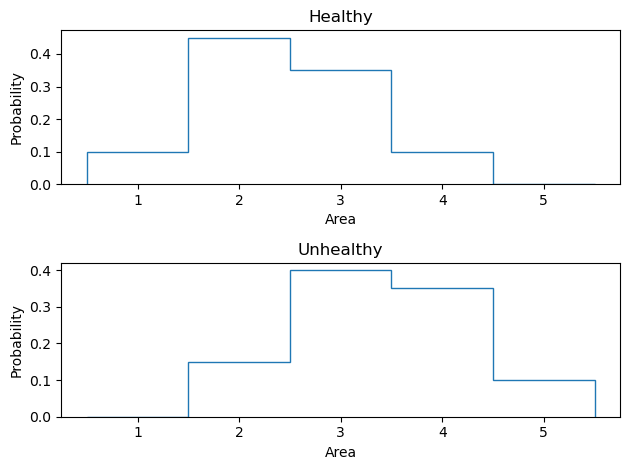

In [12]:
# Store the data of the table
bins = np.array([0.5,1.5,2.5,3.5,4.5,5.5])
area_unhealthy = np.array([0,15,40,35,10])
area_healthy = np.array([20,90,70,20,0])
# Compute the proportions/probabilities (likelihood)
prob_areaHealthy = area_healthy/np.sum(area_healthy)
prob_areaUnhealthy = area_unhealthy/np.sum(area_unhealthy)

# Represent the two histograms
plt.subplot(2, 1, 1)
plt.stairs(prob_areaHealthy,bins)
plt.title('Healthy')
plt.xlabel('Area')
plt.ylabel('Probability')


plt.subplot(2, 1, 2)
plt.stairs(prob_areaUnhealthy,bins)
plt.title('Unhealthy')
plt.xlabel('Area')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

**2.2** What is a good prior in this example for $P(unhealthy)$ and $P(healthy)$? **[2 points]**

A good prior for this example may correspond to the proportion of healthy and unhealthy people:

In [13]:
# Amount of healthy people
total_healthy = np.sum(area_healthy)
# Amount of healthy people
total_unhealthy = np.sum(area_unhealthy)
# Total amount of people
total = total_healthy + total_unhealthy
# Compute priors
prior_healthy = round(total_healthy/total,2)
prior_unhealthy = round(total_unhealthy/total,2)

$P(unhealthy) =$ {{prior_unhealthy}} and $P(healthy) =$ {{prior_healthy}}

**2.3** Compute and draw approximate curves to illustrate the posterior distributions $P(unhealthy|area)$ and $P(healthy|area)$. **[5 points]**

In order to compute the posteriors, we need to use Bayes Theorem:

\begin{equation}
\label{eq:bayes}
P(healthy|area) = \frac{P(area|healthy)*P(healthy)}{P(area)}
\end{equation}

\begin{equation}
\label{eq:bayes}
P(unhealthy|area) = \frac{P(area|unhealthy)*P(unhealthy)}{P(area)}
\end{equation}

We have all the required values to perform this computations except $P(area) = P(area|healthy) * P(healthy) + P(area|unhealthy) * P(unhealthy)$. I will compute this value and then obtain the posteriors:

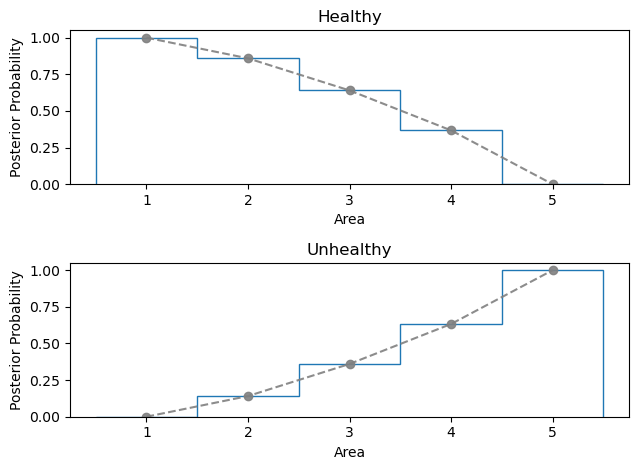

In [14]:
# Compute probability of the area
prob_area = prob_areaHealthy * prior_healthy + prob_areaUnhealthy * prior_unhealthy
# Compute the posteriors
posterior_healthy = (prob_areaHealthy * prior_healthy)/prob_area
posterior_unhealthy = (prob_areaUnhealthy * prior_unhealthy)/prob_area

# Represent the two histograms

plt.subplot(2, 1, 1)
plt.stairs(posterior_healthy,bins)
plt.plot([1,2,3,4,5], posterior_healthy, 'o--', color='grey', alpha=0.9)
plt.title('Healthy')
plt.xlabel('Area')
plt.ylabel('Posterior Probability')


plt.subplot(2, 1, 2)
plt.stairs(posterior_unhealthy,bins)
plt.plot([1,2,3,4,5], posterior_unhealthy, 'o--', color='grey', alpha=0.9)
plt.title('Unhealthy')
plt.xlabel('Area')
plt.ylabel('Posterior Probability')

plt.tight_layout()
plt.show()

**2.4** State the procedure to do maximum a posteriori (MAP) estimation. Use it to determine $unhealthy$ or $healthy$ labels for three cells, observed with sizes 5, 2 and 3.  **[5 points]**

Since I previously computed the values of the posterior probabilities for healthy and unhealthy people given the size of the cell, I just need to check the two probability values for the different sizes.

                          Posterior Probability Values
|             |  Size 1   | Size 2 |  Size 3  | Size 4 | Size 5 |
|:------------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| Unhealthy |    {{round(posterior_unhealthy[0],2)}}     |   {{round(posterior_unhealthy[1],2)}}      |    {{round(posterior_unhealthy[2],2)}} |  {{round(posterior_unhealthy[3],2)}} |       {{round(posterior_unhealthy[4],2)}}  | 
|  Healthy |     {{round(posterior_healthy[0],2)}}     |   {{round(posterior_healthy[1],2)}}      |    {{round(posterior_healthy[2],2)}} |  {{round(posterior_healthy[3],2)}} |       {{round(posterior_healthy[4],2)}}  |
    

By looking at the table I created with the values, for each cell size I will choose the label with higher probability given the size.

$P(unhealthy| Size = 5) = 1$ so for a cell size of 5, the label following a MAP estimation is __unhealthy__.

$P(healthy| Size = 2) = 0.86$ so for a cell size of 2, the label following a MAP estimation is __healthy__.

$P(unhealthy| Size = 3) = 0.64$ so for a cell size of 3, the label following a MAP estimation is __healthy__.

**2.5** State the procedure to do maximum likelihood (ML) estimation. Use it to determine $unhealthy$ or $healthy$ labels for the above three cells, observed with sizes 5, 2 and 3. **[5 points]**

Now, the process is similar to the previous exercise, but instead of showing the table for posterior probabilities, we need to take a look to the maximal likelihood probabilities.

                          Likelihood Probability Values
|             |  Size 1   | Size 2 |  Size 3  | Size 4 | Size 5 |
|:------------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| Unhealthy |    {{round(prob_areaUnhealthy[0],2)}}     |   {{round(prob_areaUnhealthy[1],2)}}      |    {{round(prob_areaUnhealthy[2],2)}} |  {{round(prob_areaUnhealthy[3],2)}} |       {{round(prob_areaUnhealthy[4],2)}}  | 
|  Healthy |     {{round(prob_areaHealthy[0],2)}}     |   {{round(prob_areaHealthy[1],2)}}      |    {{round(prob_areaHealthy[2],2)}} |  {{round(prob_areaHealthy[3],2)}} |       {{round(prob_areaHealthy[4],2)}}  |
    

$P(unhealthy| Size = 5) = 0.1$ so for a cell size of 5, the label following a ML estimation is __unhealthy__.

$P(healthy| Size = 2) = 0.45$ so for a cell size of 2, the label following a ML estimation is __healthy__.

$P(unhealthy| Size = 3) = 0.4$ so for a cell size of 3, the label following a ML estimation is __healthy__.